# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, make_scorer
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.utils.class_weight import compute_class_weight

import catboost
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from sklearn.utils import resample

from sklearn.ensemble import ExtraTreesClassifier
 

from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from pprint import pprint
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
import sklearn
from scipy.stats import linregress
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
 
import warnings
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from IPython.display import Image
 
from sklearn import set_config 
set_config(display='diagram') 

# AgroHack. Решение для 4го места

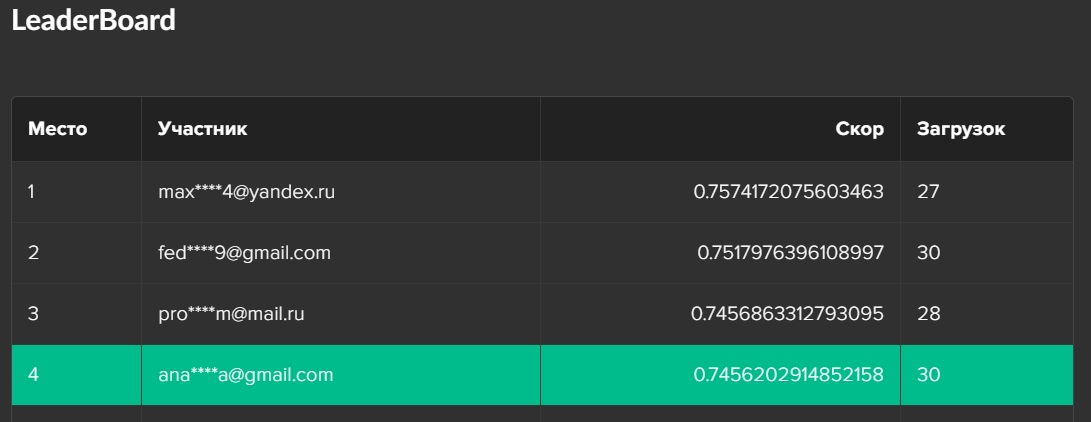

In [2]:
Image("leaderboard.jpg") 

# Clean Data

In [3]:
def Clean_Data(data, submit):
    KNN = KNNImputer(n_neighbors=2, weights ='distance')
    
    KNN.fit_transform(data[data.columns[2:-1]])
    data[data.columns[2:-1]] = KNN.transform(data[data.columns[2:-1]])  #Не учитываем только категорильные и целевую 
    
    avg = data[data.columns[100:]].mean().mean()
    
    submit[submit.columns[2:]] = KNN.transform(submit[submit.columns[2:]])
    data.fillna(avg, inplace=True) 
    
    submit.fillna(avg, inplace=True) 
    return data.copy(deep=True), submit.copy(deep=True)

 

# Balance Data

In [4]:
from sklearn.utils import shuffle
from sklearn.utils import resample
def Balance_Data(data):
    COLUMNS = data.columns
    df_majority = data[data['Culture']==4]
    print(df_majority.shape)
    LIMIT = 3 # Ставим на уровне 3, чтобы дальнейшая кросвалидаци по 3м фолдам работала без проблем
    for cla in data['Culture'].unique():
        if cla!=4:
            df_minority = data[data['Culture']==cla].copy(deep=True)
            L = len(df_minority)
            if L < 3:                         # sample with replacement # to match majority class
                df_minority = resample(df_minority, replace=True, n_samples=LIMIT, random_state=42).copy(deep=True)  
            df_majority = pd.concat([df_majority, df_minority], ignore_index=True)
    return df_majority.copy(deep=True)
    

In [5]:
data = pd.read_csv('train.csv')
submit = pd.read_csv('test.csv')


data, submit = Clean_Data(data, submit)  # Заполнялем пробелы KNNimputer
data = Balance_Data(data)  # Балансируем классы


d_other =  data[data.columns[:3]]
col_other = d_other.columns
col_ser = data.columns[3:-1]
 
data.head()

(1301, 370)


,Year,Field ID,Field Area,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,...,Day 358,Day 359,Day 360,Day 361,Day 362,Day 363,Day 364,Day 365,Day 366,Culture
0,2018,517,48.64,0.5369,0.5371,0.5375,0.5379,0.5384,0.5390,0.5397,...,0.4362,0.4322,0.4283,0.4243,0.4203,0.4163,0.4123,0.4084,0.087015,4
1,2018,1591,79.34,0.4827,0.4576,0.4324,0.4073,0.3821,0.3570,0.3318,...,0.2657,0.2668,0.2680,0.2692,0.2705,0.2717,0.2730,0.2743,0.265153,4
2,2017,681,144.76,-0.0202,-0.0191,-0.0181,-0.0170,-0.0160,-0.0150,-0.0140,...,-0.0354,-0.0358,-0.0361,-0.0365,-0.0369,-0.0372,-0.0376,-0.0379,-0.048029,4
3,2018,833,104.40,0.5751,0.5723,0.5694,0.5664,0.5634,0.5603,0.5571,...,0.1990,0.1998,0.2005,0.2013,0.2020,0.2028,0.2035,0.2043,0.047997,4
4,2018,1747,124.16,0.6112,0.6080,0.6048,0.6017,0.5985,0.5953,0.5922,...,0.2597,0.2598,0.2600,0.2601,0.2603,0.2604,0.2606,0.2607,0.124179,4


# Извлечение признаков из временного ряда

In [6]:
from tsfresh.feature_extraction import ComprehensiveFCParameters
def extr_features(data, istrain=True):
    d = data[data.columns[3:]].copy(deep=True)
    d.columns = list(range(1, len(d.columns)+1))
    columns = list( d.columns )
    if istrain == True:
        columns.pop()
        columns.append( 'target' )
        d.columns = columns
        y = d.target
    d.columns = columns
    
    if istrain == True:
        d.drop('target', axis = 1, inplace = True )  
    d = d.stack().copy()
    d.index.rename([ 'id', 'time' ], inplace = True )
    d = d.reset_index()
    print(len(d))
    print(d.head(2))
    extraction_settings = ComprehensiveFCParameters()
    with warnings.catch_warnings(): # doesn't work too well
        warnings.simplefilter( "ignore" )
        f = extract_features( d, column_id = "id", column_sort = "time", default_fc_parameters=extraction_settings, n_jobs=8)  
    if istrain == True:
        f['y'] = y
        f[data.columns[:-1]] = data[data.columns[:-1]].values 
    else:
        f[data.columns[:]] = data[data.columns[:]].values  
    print(f.shape)
    f.dropna(axis=1, inplace=True )
    print(f.shape)
    return f.copy(deep=True)
   

In [7]:
# about 3 mins for extraction
train_extr = extr_features(data, istrain=True)
train_extr.head()

# about 1 min for extraction
submit_extr = extr_features(submit, istrain=False)
submit_extr.head(3)

Feature Extraction:   0%|                                                                       | 0/40 [00:00<?, ?it/s]

1041636
   id  time       0
0   0     1  0.5369
1   0     2  0.5371


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [03:23<00:00,  5.10s/it]


(2846, 1149)
(2846, 1144)
343674
   id  time       0
0   0     1 -0.0047
1   0     2 -0.0051


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [01:22<00:00,  2.07s/it]


(939, 1148)
(939, 1143)


,0__variance_larger_than_standard_deviation,0__has_duplicate_max,0__has_duplicate_min,0__has_duplicate,0__sum_values,0__abs_energy,0__mean_abs_change,0__mean_change,0__mean_second_derivative_central,0__median,...,Day 357,Day 358,Day 359,Day 360,Day 361,Day 362,Day 363,Day 364,Day 365,Day 366
0,0.0,0.0,0.0,1.0,106.849961,58.136354,0.005975,0.000005,-0.000084,0.238000,...,0.063161,0.062618,0.062071,0.061528,0.061033,0.060437,0.059895,0.059399,0.058857,-0.002821
1,0.0,0.0,0.0,1.0,171.109653,95.987875,0.004955,-0.000063,-0.000024,0.335600,...,0.284454,0.278884,0.273361,0.267738,0.262168,0.256597,0.250974,0.245452,0.239881,0.221408
2,0.0,0.0,0.0,1.0,109.026397,62.720094,0.006599,0.000808,0.000116,0.233301,...,0.241817,0.240442,0.239067,0.237791,0.236465,0.235190,0.233914,0.232688,0.231412,0.309394


# Генерация новых признаков

In [10]:

def generate_feature(data):
    l1 = len(data.columns)
    
    def get_lin_k_l(x):
        filtered = x[x > 0.4].reset_index(drop=True)
        try: m = filtered.argmax()
        except: return -1
        
        LH = filtered[:m]
        slope1, intercept1, _, _, _ = linregress(np.arange(len(LH)), LH)
        return slope1*100 

    def get_lin_k_r(x):
        filtered = x[x > 0.4].reset_index(drop=True)
        try: m = filtered.argmax()
        except: return -1

        RH = filtered[m:]
        slope2, intercept2, _, _, _ = linregress(np.arange(len(RH)), RH)
        return slope2*100 
     
    def get_data(s):
        return int(s.split()[-1])
    
    def get_LH_argmax(x):
        filtered = x.reset_index(drop=True)
        LH = filtered[:250]
        LH_argmax = LH.argmax()    
        return LH_argmax 
    def get_RH_argmax(x):
        filtered = x.reset_index(drop=True)
        RH = filtered[250:]
        RH_argmax = RH.argmax()+250        
        return RH_argmax

    def get_delta_argmax(x):
        filtered = x.reset_index(drop=True)
        LH = filtered[:250]
        RH = filtered[250:]
        LH_argmax, RH_argmax = LH.argmax(), RH.argmax()+250         
        delta_argmax = RH_argmax-LH_argmax

        return delta_argmax 
    def get_LH_max(x):
        filtered = x.reset_index(drop=True)
        LH,RH = filtered[:250],filtered[250:]
        LH_argmax, RH_argmax = LH.argmax(), RH.argmax()+250            
        LH_max = filtered[LH_argmax] 
        return LH_max
    def get_RH_max(x):
        filtered = x.reset_index(drop=True)
        LH,RH = filtered[:250],filtered[250:]
        LH_argmax, RH_argmax = LH.argmax(), RH.argmax()+250           
        RH_max = filtered[RH_argmax]
        return RH_max


    def get_less_left(x):
        filtered = x.reset_index(drop=True)
        argma = filtered.argmax()
        Left_H = filtered[:argma]
        Less_left_N = len(Left_H[Left_H < 0.1])
        return Less_left_N
    
    
    def get_less_left_sum(x):
        filtered = x.reset_index(drop=True)
        argma = filtered.argmax()
        Left_H = filtered[:argma]
        Less_left_sum = np.sum(Left_H[Left_H < 0.1])
        return Less_left_sum
   
    data['max_day'] = data[col_ser].idxmax(axis="columns") # день через который начинается пик
    data['max_day'] =data['max_day'].apply(get_data)# день через который начинается пик числом
    data['max'] = data[col_ser].max(axis=1) # максимум

    data['less_left_10'] = data[col_ser].apply(get_less_left, axis=1)  # Количесво значений ниже 0.10 слева от пика
    data['less_left_sum'] = data[col_ser].apply(get_less_left_sum, axis=1) # Сумма индексов слева от пика ниже 0.10
   
    data['RH_argmax'] = data[col_ser].apply(get_RH_argmax, axis=1) # Еще пики справа по мимо главного
    data['delta_argmax'] = data[col_ser].apply(get_delta_argmax, axis=1)  #Расстояние между пиками
 
    data['less20'] = (data[col_ser] < 0.2).sum(axis=1)
    data['less10'] = (data[col_ser] < 0.1).sum(axis=1)
    data['width_70'] = (data[col_ser] > 0.7).sum(axis=1)
    data['width_80'] = (data[col_ser] > 0.8).sum(axis=1)
    data['width_90'] = (data[col_ser] > 0.9).sum(axis=1)
    data['width_60'] = (data[col_ser] > 0.6).sum(axis=1)
    data['width_75'] = (data[col_ser] > 0.75).sum(axis=1)
    
    data['plato_2_4'] = abs((data[col_ser] > 0.1).sum(axis=1) - (data[col_ser] < 0.4).sum(axis=1)) 
    
    l2 = len(data.columns)
    print('Сгенериривал еще: ', l2-l1, 'фичей')
    
    generated_features = ['LH_argmax','RH_argmax','delta_argmax','LH_max','RH_max',
                          'width_75', 'width_60', 'width_70','width_80', 'width_90',
                          'less20', 'less10', 'max_day','max', 'plato_2_4',
                          'less_left_10','less_left_sum']
    
    return data, generated_features

 
train_extr_gener, generated_features = generate_feature(train_extr)
submit_extr_gener, generated_features = generate_feature(submit_extr)


Сгенериривал еще:  14 фичей
Сгенериривал еще:  14 фичей


# Отбор признаков

In [11]:
import pandas as pd
from tsfresh import extract_features, select_features

def sel_features(features, fdr_level = 0.01):
    train_x = features.drop( ['y'], axis = 1 )
    train_y = features.y
    print("selecting features...")
    train_features_selected = select_features(train_x, train_y, fdr_level = fdr_level, n_jobs=8)
    print("selected {} features.".format( len(train_features_selected.columns )))
    train = train_features_selected.copy(deep=True)
    features_selected_columns = train.columns
    train['y'] = train_y
    return train, features_selected_columns


train_extr_sel, train_features_selected = sel_features(train_extr_gener)    
submit_extr_sel  = submit_extr_gener[train_features_selected]
 

selecting features...
selected 1093 features.


# Визуализация данных

# Подготовка данных для Pipelin'ов

In [12]:
x_train = train_extr_sel.drop( 'y', axis = 1 )
y_train = train_extr_sel.y  

In [13]:

cat_cols = ['Year', 'Field ID']    #'Year'
num_cols = ['Field Area'] + list(train_features_selected) # Второе слагаемое это фичи 
num_cols = [i for i in train_features_selected if i not in col_ser]

ser_cals = col_ser # слагаемое это дни 
nstd_cals = ['nested']

all_init_cals = ['Field Area'] + list(col_ser)  # изначальные численные признаки
hand_made_num = generated_features  # фичи, которые мы сгенерили

In [14]:
class_weights = list(compute_class_weight(class_weight='balanced', 
                                          classes=np.unique(data['Culture']),
                                          y=data['Culture']))
numerical_features = num_cols
categorical_features =  cat_cols
series_features = ser_cals
nested_features = nstd_cals

hm_numerical_features = ['max_day', 'max', 
                         'width_70', 'width_60', 'width_80',
                         'less10',] #hand_made_num

# Модель  Extra Tree 

In [15]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_classification

ETC = ExtraTreesClassifier(max_depth=16, 
                           n_estimators=1070,
                            n_jobs=-1,
                           class_weight='balanced',
                           random_state=42)
 

# Категориальные признаки
categorical_features =  cat_cols
#Числовые признаки
numerical_features = all_init_cals
 

hand_made_numerical_features = ['max_day', 'max', 'RH_argmax',
                         'width_70', 'width_60', 'width_80',
                         'less10', 'less_left_10','less_left_sum']  # 'plato_2_4'

 
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer() ),
                                        ('scaler',  StandardScaler()),
                                        ('fs', SelectKBest(score_func=f_classif, k=190))])

hand_made_numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer()),
                                           ('scaler',  StandardScaler()),])
 

# Применение SimpleImputer, а затем OneHotEncoder
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer()),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Собираем воедино трансформеры для числовых и категориальных признаков
data_transformer = ColumnTransformer(transformers=[
                                    ('numerical', numerical_transformer, numerical_features),
                                    ('categorical', categorical_transformer, categorical_features),
                                    ('hand_made', hand_made_numerical_transformer, hand_made_numerical_features)])

# Создание конвейера препроцессора, который сначала преобразует данные и затем применяет PCA.
preprocessor = Pipeline(steps=[('data_transformer', data_transformer)])#, 
                               

classifier_ETC = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', ETC)])

classifier_ETC

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('fs',
                                                                                    SelectKBest(k=190))]),
                                                                   ['Field '
                                                                    'Area',
                                                                    'Day 1',
                                                                    'Day 2',
                                                                    'Day 3',
                                                                    'Day 4',
                                                                    'Day 5',
                                                                    'Day 6',
                                                                    'Day 7',
                                                                    'Day 8',
                                                                    'Day 9',
                                                                    'Day 10',
                                                                    'Day 11',
                                                                    'Day 12',
                                                                    'Day 13',
                                                                    'Day 14',
                                                                    'Day 15',
                                                                    'Day 16',
                                                                    'Da...
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Year',
                                                                    'Field '
                                                                    'ID']),
                                                                  ('hand_made',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['max_day',
                                                                    'max',
                                                                    'RH_argmax',
                                                                    'width_70',
                                                                    'width_60',
                                                                    'width_80',
                                                                    'less10',
                                                                    'less_left_10',
                                                                    'less_left_sum'])]))])),
                ('classifier',
                 ExtraTreesClassifier(class_weight='balanced', max_depth=16,
                                      n_estimators=1070, n_jobs=-1,
                                     

In [16]:
classifier_ETC.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('fs',
                                                                                    SelectKBest(k=190))]),
                                                                   ['Field '
                                                                    'Area',
                                                                    'Day 1',
                                                                    'Day 2',
                                                                    'Day 3',
                                                                    'Day 4',
                                                                    'Day 5',
                                                                    'Day 6',
                                                                    'Day 7',
                                                                    'Day 8',
                                                                    'Day 9',
                                                                    'Day 10',
                                                                    'Day 11',
                                                                    'Day 12',
                                                                    'Day 13',
                                                                    'Day 14',
                                                                    'Day 15',
                                                                    'Day 16',
                                                                    'Da...
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Year',
                                                                    'Field '
                                                                    'ID']),
                                                                  ('hand_made',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['max_day',
                                                                    'max',
                                                                    'RH_argmax',
                                                                    'width_70',
                                                                    'width_60',
                                                                    'width_80',
                                                                    'less10',
                                                                    'less_left_10',
                                                                    'less_left_sum'])]))])),
                ('classifier',
                 ExtraTreesClassifier(class_weight='balanced', max_depth=16,
                                      n_estimators=1070, n_jobs=-1,
                                     

# Анализ ошибок

Используя модель Extra Tree было обнаружили, что модель делает неверный выбор между классами 8 и 5, 3 и 7 а так же 4 и 28.

Выжав из временного ряда еще больше фичей, был собран классификатор, который будет заточен под более точное определение нужного класса в случае, если модель решила, что перед ней класс 8 или 5, 3 или 7 и 4 или 28.

# Extra TREE + Feature Exctraction

In [17]:
from sklearn.ensemble import ExtraTreesClassifier

In [18]:
ETC = ExtraTreesClassifier(max_depth=17, 
                           n_estimators=1100,
                           class_weight='balanced',
                           n_jobs=-1,
                           random_state=42)
 

# Категориальные признаки
categorical_features =  cat_cols
numerical_features = num_cols
 
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer() ),
                                        ('scaler',  StandardScaler()) ,
                                        ('fs', SelectKBest(score_func=f_classif, k=177))])
                                       #('reduce_dim', PCA() )]) #TruncatedSVD

    
hand_made_numerical_features = ['max_day', 'max', 'RH_argmax', 'delta_argmax', 
                         'width_70', 'width_60', 'width_80',
                         'less10', 'less_left_10','less_left_sum',]  # 'plato_2_4'

 
hand_made_numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer() ),
                                        ('scaler',  StandardScaler() ),])
                                        #('FS', SelectKBest(score_func=f_classif, k=100) ) ])
                                       #('reduce_dim', PCA() )]) #TruncatedSVD

# Применение SimpleImputer, а затем OneHotEncoder
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer()),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])


# Собираем воедино трансформеры для числовых и категориальных признаков
data_transformer = ColumnTransformer(transformers=[
                                    ('numerical', numerical_transformer, numerical_features),
                                    ('categorical', categorical_transformer, categorical_features),
                                    ('hand_made', hand_made_numerical_transformer, hand_made_numerical_features)])
                                    #('series', series_transformer, series_features),
                                    #('nested', nested_transformer, nested_features)])


# Создание конвейера препроцессора, который сначала преобразует данные и затем применяет PCA.
preprocessor = Pipeline(steps=[('data_transformer', data_transformer)])#, 
                               #('reduce_dim', TruncatedSVD())])

classifier_ETC_EF = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', ETC)])

classifier_ETC_EF

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('fs',
                                                                                    SelectKBest(k=177))]),
                                                                   ['0__index_mass_quantile__q_0.3',
                                                                    '0__linear_trend__attr_"rvalue"',
                                                                    '0__linear_trend__attr_"intercept"',
                                                                    '0__linear_trend__attr_"slope"',
                                                                    '0_...
                                                                   ['Year',
                                                                    'Field '
                                                                    'ID']),
                                                                  ('hand_made',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['max_day',
                                                                    'max',
                                                                    'RH_argmax',
                                                                    'delta_argmax',
                                                                    'width_70',
                                                                    'width_60',
                                                                    'width_80',
                                                                    'less10',
                                                                    'less_left_10',
                                                                    'less_left_sum'])]))])),
                ('classifier',
                 ExtraTreesClassifier(class_weight='balanced', max_depth=17,
                                      n_estimators=1100, n_jobs=-1,
                                      random_state=42))])

# Модель ExraTree + FeatureExctractor как бинарный классификатор для похожих классов

In [19]:
ETC = ExtraTreesClassifier(max_depth=16, 
                           n_estimators=385,  
                            n_jobs=-1,
                           class_weight='balanced',
                           random_state=42)
 
categorical_features =  cat_cols
numerical_features = num_cols
 

hand_made_numerical_features = ['max_day', 'max', 'RH_argmax', 
                         'width_70', 'width_60', 'width_80',
                         'less10', 'less_left_10','less_left_sum']   

 
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer() ),
                                        ('scaler',  StandardScaler()),
                                        ('fs', SelectKBest(score_func=f_classif, k=195))])
                                       

hand_made_numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer()),
                                           ('scaler',  StandardScaler())])


# Применение SimpleImputer, а затем OneHotEncoder
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer()),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Собираем воедино трансформеры для числовых и категориальных признаков
data_transformer = ColumnTransformer(transformers=[
                                    ('numerical', numerical_transformer, numerical_features),
                                    ('categorical', categorical_transformer, categorical_features),
                                    ('hand_made', hand_made_numerical_transformer, hand_made_numerical_features)])
                                    

# Создание конвейера препроцессора, который сначала преобразует данные 
preprocessor = Pipeline(steps=[('data_transformer', data_transformer)])  
                              

classifier_ETC_binar  = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', ETC)])

 
classifier_ETC_binar 

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('fs',
                                                                                    SelectKBest(k=195))]),
                                                                   ['0__index_mass_quantile__q_0.3',
                                                                    '0__linear_trend__attr_"rvalue"',
                                                                    '0__linear_trend__attr_"intercept"',
                                                                    '0__linear_trend__attr_"slope"',
                                                                    '0_...
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['Year',
                                                                    'Field '
                                                                    'ID']),
                                                                  ('hand_made',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['max_day',
                                                                    'max',
                                                                    'RH_argmax',
                                                                    'width_70',
                                                                    'width_60',
                                                                    'width_80',
                                                                    'less10',
                                                                    'less_left_10',
                                                                    'less_left_sum'])]))])),
                ('classifier',
                 ExtraTreesClassifier(class_weight='balanced', max_depth=16,
                                      n_estimators=385, n_jobs=-1,
                                      random_state=42))])

# Catboost

In [23]:
hm_numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer() ),
#                                         ('scaler',  StandardScaler()),
                                           ])
                                       # ('fs', SelectKBest(score_func=f_classif, k=100))])
    
# Применяем SimpleImputer и будем искать различные скейлеры с помощью GridSearchCV
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer() ),
#                                         ('scaler',  StandardScaler()),
                                        ('fs', SelectKBest(score_func=f_classif, k=190)) ])                                     

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer()),
#                                           ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                         ])

series_transformer = Pipeline(steps=[('imputer_ser', KNNImputer(n_neighbors=9, weights="uniform")),
#                                     ('scaler',  StandardScaler()),
#                                     ('fs', SelectKBest(score_func=f_classif, k=190)),
                                    ])                                      

# Собираем воедино трансформеры для числовых и категориальных признаков
data_transformer = ColumnTransformer(transformers=[
                                    ('numerical', numerical_transformer, numerical_features),
                                    ('categorical', categorical_transformer, categorical_features),#])
                                     ('hand_made', hm_numerical_transformer, hm_numerical_features),#])
                                    ('series', series_transformer, series_features),])
                                     

# Создание конвейера препроцессора, который сначала преобразует данные и затем применяет PCA.
preprocessor = Pipeline(steps=[('data_transformer', data_transformer)])
                               #('reduce_dim', TruncatedSVD())])
classifier_ctb = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', catboost.CatBoostClassifier(iterations=1000, random_state=42))])
#max_depth=6, n_estimators=305
#max_depth = 5, n_estimators=350, colsample_bytree = 0.7
classifier_ctb

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('fs',
                                                                                    SelectKBest(k=190))]),
                                                                   ['0__index_mass_quantile__q_0.3',
                                                                    '0__linear_trend__attr_"rvalue"',
                                                                    '0__linear_trend__attr_"intercept"',
                                                                    '0__linear_trend__attr_"slope"',
                                                                    '0__agg_linear_trend__attr_"rva...
                                                                  ('series',
                                                                   Pipeline(steps=[('imputer_ser',
                                                                                    KNNImputer(n_neighbors=9))]),
                                                                   Index(['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5', 'Day 6', 'Day 7', 'Day 8',
       'Day 9', 'Day 10',
       ...
       'Day 357', 'Day 358', 'Day 359', 'Day 360', 'Day 361', 'Day 362',
       'Day 363', 'Day 364', 'Day 365', 'Day 366'],
      dtype='object', length=366))]))])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x0000028663796A88>)])

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, 
                 stratify=y_train, random_state=42)

In [25]:
classifier_ctb.fit(x_train, y_train)  
classifier_ctb_preds = classifier_ctb.predict(submit_extr_sel)  

Learning rate set to 0.5
0:	learn: 1.5564657	total: 2.58s	remaining: 0us


In [26]:
classifier_ctb_preds_resh =  classifier_ctb_preds[:, 0]

# Стекинг моделей Extra Tree (без FE) и Catboost

In [27]:
a = 0.57 
st_sol = pd.Series(((classifier_ctb.predict_proba(submit_extr_sel) * a
                     + classifier_ETC.predict_proba(submit_extr_sel) * (1-a)).argmax(1) + 1))

# Теперь исправим ошибки стекинга с помощь Extra Tree + Feature Extractor

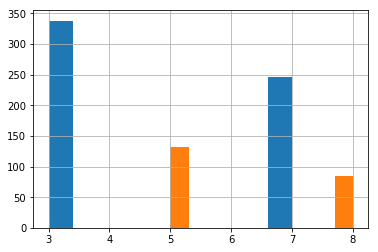

In [32]:
#Кусок тренировочных данных для классов 3 и 7, чтобы обучить по бинарный классификатор.
train_37 = train_extr_sel[(train_extr_sel.y==3) | (train_extr_sel.y==7)].copy(deep=True)
x_train_37 = train_37.drop( 'y', axis = 1 )
y_train_37 = train_37.y 
y_train_37.hist() 
    
    
# Аналогично для классов 5 и 8  
train_58 = train_extr_sel[(train_extr_sel.y==5) | (train_extr_sel.y==8)].copy(deep=True)
x_train_58 = train_58.drop( 'y', axis = 1 )
y_train_58 = train_58.y 
y_train_58.hist()


#Для классов 13 и 4 модель почти не улучшалось. Финальный сабмит по этим двум классам не реактировался. 
# train_134 = train_extr_sel[(train_extr_sel.y==13) | (train_extr_sel.y==4)].copy(deep=True)
# x_train_134 = train_134.drop( 'y', axis = 1 )
# y_train_134 = train_134.y    

D:\Users\sasha\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [161 604 643] are constant.
  UserWarning)
D:\Users\sasha\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
D:\Users\sasha\Anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
D:\Users\sasha\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [503 584 604 643] are constant.
  UserWarning)
D:\Users\sasha\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
D:\Users\sasha\Anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:440: F

Видно, что распределение по сложноразличимым классам после корректировки изменилось


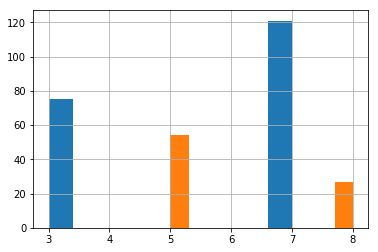

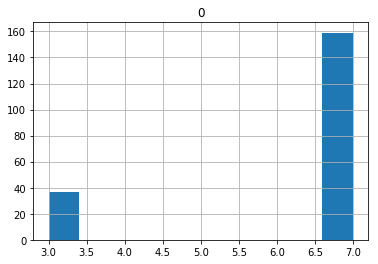

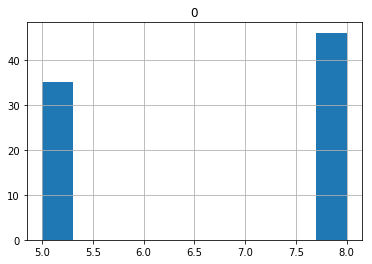

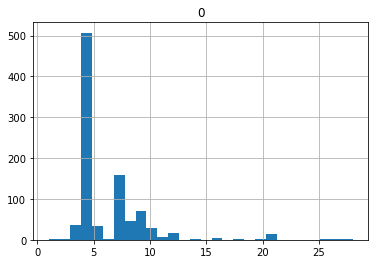

In [33]:
preds_ETC = st_sol 

submit_extr_sel_for_binar = submit_extr_sel.copy(deep=True)

submit_extr_sel_for_binar['y_pred'] = preds_ETC
for_binar_37 = submit_extr_sel_for_binar[(submit_extr_sel_for_binar.y_pred==3) | (submit_extr_sel_for_binar.y_pred==7)].copy()
for_binar_37.y_pred.hist()

for_binar_134 = submit_extr_sel_for_binar[(submit_extr_sel_for_binar.y_pred==13) | (submit_extr_sel_for_binar.y_pred==4)].copy()
#for_binar_134.y_pred.hist()


for_binar_58 = submit_extr_sel_for_binar[(submit_extr_sel_for_binar.y_pred==5) | (submit_extr_sel_for_binar.y_pred==8)].copy()
for_binar_58.y_pred.hist()

 
classifier_ETC_binar.fit(x_train_37  , y_train_37)  
preds_ETC_binar_37 = classifier_ETC_binar.predict(for_binar_37)     #classifier_xgb
 
classifier_ETC_binar.fit(x_train_58 , y_train_58)  
preds_ETC_binar_58 = classifier_ETC_binar.predict(for_binar_58)     #classifier_xgb


# classifier_ETC_binar.fit(x_train_134 , y_train_134)  
# preds_ETC_binar_134 = classifier_ETC_binar.predict(for_binar_134)     #classifier_xgb

pd.DataFrame(preds_ETC_binar_37).hist()
pd.DataFrame(preds_ETC_binar_58).hist()


submit_extr_sel_for_binar.loc[(submit_extr_sel_for_binar.y_pred==3) | 
                          (submit_extr_sel_for_binar.y_pred==7), 'y_pred'] = preds_ETC_binar_37

# submit_extr_sel_for_binar.loc[(submit_extr_sel_for_binar.y_pred==13) | 
#                           (submit_extr_sel_for_binar.y_pred==4), 'y_pred'] = preds_ETC_binar_134

submit_extr_sel_for_binar.loc[(submit_extr_sel_for_binar.y_pred==5) |
                          (submit_extr_sel_for_binar.y_pred==8), 'y_pred'] = preds_ETC_binar_58


new_aswer = submit_extr_sel_for_binar['y_pred'].values
 
pd.DataFrame(new_aswer).hist(bins=28)
pd.DataFrame(new_aswer).value_counts()

print('Видно, что распределение по сложноразличимым классам после корректировки изменилось')

# Подготовка сабмита

In [31]:
pd.Series(new_aswer).to_csv('best.csv', index=False, header=['Culture']) # 0.7456 the best sub!!!!!!

# Замечание

При решении этого хакатона, конечно, было проверенно намного больше гипотез, чем в этом ноутбуке, но для простоты восприятия, была сделана выжимка кода и оставлены только те фрагменты, которые сработали и дали лучший результат на борде. 

Были убраны модели, которые показали плохие результаты (RandomForest, KNN, XGBoost и тп). 
Так же удалена оптимизация по параметрами моделей с помощью GridSerchCV.